In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import matplotlib.pyplot as plt
import cv2
import keras
%matplotlib inline

In [3]:
# UNZIP THE DATASET
import zipfile

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test1'

### Data Preprocessing

In [4]:
import glob
glob.glob("/kaggle/working/train/*.jpg")[:5]

['/kaggle/working/train/cat.3327.jpg',
 '/kaggle/working/train/cat.9684.jpg',
 '/kaggle/working/train/cat.660.jpg',
 '/kaggle/working/train/dog.5359.jpg',
 '/kaggle/working/train/cat.5596.jpg']

In [5]:
file = 'dog.9281.jpg'
file.split('.')[0]

'dog'

In [6]:
categories = []

for file in os.listdir(train_path):
    category = file.split('.')[0]
    
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
# 0 for CAT
# 1 for DOG

categories[:5]

[0, 0, 0, 1, 0]

In [7]:
# Create dataframe with CAT(0)-DOG(1) labels:
train_set = pd.DataFrame({'file': os.listdir(train_path), 'label':categories})

In [8]:
train_set.head()

,file,label
0,cat.3327.jpg,0
1,cat.9684.jpg,0
2,cat.660.jpg,0
3,dog.5359.jpg,1
4,cat.5596.jpg,0


(-0.5, 499.5, 373.5, -0.5)

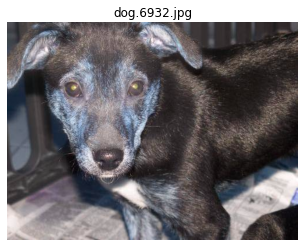

In [9]:
image_id = os.listdir(train_path)[np.random.randint(100)]
image = cv2.imread(train_path + f'/{image_id}')
plt.imshow(image)
plt.title(image_id)
plt.axis('off')

#### Load Train and Test Data

In [10]:
train_set.shape

(25000, 2)

In [11]:
# Shuffle (optional)
# train_set = train_set.sample(frac=1)

split the data into train(80%) and test(20%) set

In [12]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(train_set, test_size = 0.2)

In [13]:
print('no of Training data: ' + str(train.shape[0]))
print('no of Test data: ' + str(test.shape[0]))

no of Training data: 20000
no of Test data: 5000


In [14]:
test

,file,label
527,cat.9781.jpg,0
18268,dog.4390.jpg,1
24583,dog.4306.jpg,1
538,dog.1319.jpg,1
4539,dog.4852.jpg,1
...,...,...
14902,cat.2310.jpg,0
12531,cat.6058.jpg,0
9041,cat.386.jpg,0
15405,cat.7052.jpg,0


In [15]:
def load_data():
    path = train_path
    
    dataframes = [train, test]
    
    output = []
    
    for df in dataframes:
        images = []
        labels = []
        
        for i in range(len(df)):
            file = df.iloc[i]['file']
            
            img_path = path + f'/{file}'
            
            # open (and resize the image)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150,150))
            
            images.append(image)
            labels.append(df.iloc[i]['label'])
        
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
    
    
    return output
    
#     returns [(x_train, y_train), (x_test, y_test)]

In [16]:
(x_train, y_train), (x_test, y_test) = load_data()

In [17]:
print("x_train.shape: " + str(x_train.shape))
print("y_train.shape: " + str(y_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_test.shape: " + str(y_test.shape))

x_train.shape: (20000, 150, 150, 3)
y_train.shape: (20000,)
x_test.shape: (5000, 150, 150, 3)
y_test.shape: (5000,)


In [18]:
# Prepare the labels
from keras.utils import np_utils
num_classes = len(np.unique(y_train))
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [19]:
# Rescale the images
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [20]:
# Divide the train set into Train(80% - 16000) and Validation(20% - 4000)
x_val = x_train[:4000]
y_val = y_train[:4000]
x_train = x_train[4000:]
y_train = y_train[4000:]

In [21]:
print("x_train.shape: " + str(x_train.shape))
print("y_train.shape: " + str(y_train.shape))
print("x_val.shape: " + str(x_val.shape))
print("y_val.shape: " + str(y_val.shape))

x_train.shape: (16000, 150, 150, 3)
y_train.shape: (16000, 2)
x_val.shape: (4000, 150, 150, 3)
y_val.shape: (4000, 2)


# Define The Model

In [22]:
# CNN : INPUT -> CONV1 -> CONV2 -> POOL1 -> CONV3 -> POOL2 -> FLATTEN -> DROPOUT -> FC1 ->  FC2(SIGMOID)
# DEFINE THE MODEL USING FUNCTIONAL API

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense

input_layer = Input(shape=(150,150,3))
conv1 = Conv2D(16, kernel_size=(3,3), strides=1, padding='same', activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

conv2 = Conv2D(32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

conv3 = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

conv4 = Conv2D(128,kernel_size=(3,3), strides=1, padding='same', activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

flat = Flatten()(pool4)
do1 = Dropout(0.4)(flat)
dense1 = Dense(400, activation='relu')(do1)
output_layer = Dense(2, activation='sigmoid')(dense1)

model = Model(inputs=input_layer, outputs = output_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0     

2023-01-04 20:14:59.140967: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model

In [24]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=2, callbacks=[checkpointer], validation_data=(x_val, y_val))

2023-01-04 20:15:04.877084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
500/500 - 120s - loss: 0.6487 - accuracy: 0.6069 - val_loss: 0.5972 - val_accuracy: 0.6812

Epoch 00001: val_loss improved from inf to 0.59717, saving model to model.weights.best.hdf5
Epoch 2/10
500/500 - 114s - loss: 0.5272 - accuracy: 0.7356 - val_loss: 0.4780 - val_accuracy: 0.7667

Epoch 00002: val_loss improved from 0.59717 to 0.47796, saving model to model.weights.best.hdf5
Epoch 3/10
500/500 - 115s - loss: 0.4396 - accuracy: 0.7937 - val_loss: 0.4289 - val_accuracy: 0.8005

Epoch 00003: val_loss improved from 0.47796 to 0.42894, saving model to model.weights.best.hdf5
Epoch 4/10
500/500 - 114s - loss: 0.3786 - accuracy: 0.8267 - val_loss: 0.3634 - val_accuracy: 0.8420

Epoch 00004: val_loss improved from 0.42894 to 0.36343, saving model to model.weights.best.hdf5
Epoch 5/10
500/500 - 115s - loss: 0.3219 - accuracy: 0.8596 - val_loss: 0.3324 - val_accuracy: 0.8515

Epoch 00005: val_loss improved from 0.36343 to 0.33242, saving model to model.weights.best.hdf5
Epoch 6/1

In [25]:
model.load_weights('model.weights.best.hdf5')

In [26]:
score = model.evaluate(x_test, y_test)

157/157 [==============================] - 10s 65ms/step - loss: 0.3095 - accuracy: 0.8762


In [27]:
print('Accuracy = ' + str(score[1]))

Accuracy = 0.8762000203132629


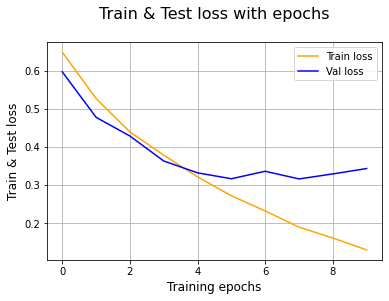

In [28]:
plt.plot(hist.history['loss'], color='orange', label='Train loss')
plt.plot(hist.history['val_loss'], color='blue', label='Val loss')
plt.grid(True)
plt.title("Train & Test loss with epochs\n", fontsize=16)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Train & Test loss", fontsize=12)
plt.legend()

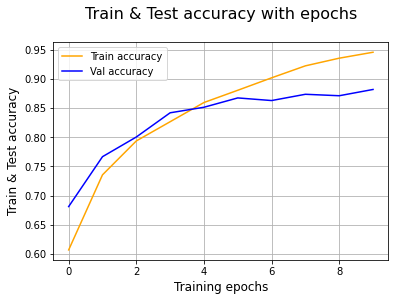

In [29]:
plt.plot(hist.history['accuracy'], color='orange', label='Train accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='Val accuracy')
plt.grid(True)
plt.title("Train & Test accuracy with epochs\n", fontsize=16)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Train & Test accuracy", fontsize=12)
plt.legend()

# Make Predictions for new data

In [30]:
glob.glob("/kaggle/working/test1/*.jpg")[:5]

['/kaggle/working/test1/1278.jpg',
 '/kaggle/working/test1/4712.jpg',
 '/kaggle/working/test1/66.jpg',
 '/kaggle/working/test1/332.jpg',
 '/kaggle/working/test1/12432.jpg']

### Prepare the test data

In [31]:
test_path
test_img = []

for file in os.listdir(test_path):
    img_path = test_path + f'/{file}'
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150,150))
    
    test_img.append(image)
    
test_img = np.array(test_img, dtype= 'float32')

# Rescale the images
test_img = test_img.astype('float32')/255

In [32]:
test_img.shape

(12500, 150, 150, 3)

### Make Predictions

In [33]:
predictions = model.predict(test_img)

In [34]:
predictions

array([[8.7377775e-01, 1.3858810e-01],
       [9.9428558e-01, 5.4791272e-03],
       [4.5404375e-02, 9.7274673e-01],
       ...,
       [9.9921215e-01, 8.4972382e-04],
       [2.8008044e-02, 9.7252417e-01],
       [7.1188897e-02, 9.3731493e-01]], dtype=float32)

In [35]:
predict_labels = [int(round(p[1])) for p in predictions]

#### Display Sample Predictions:

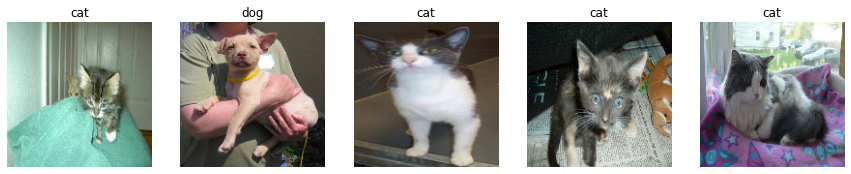

In [36]:
fig = plt.figure(figsize=(15,30))
rows, cols = (1, 5)

for i in range(5):
    idx = np.random.randint(test_img.shape[0])
    label = 'dog' if predict_labels[idx]==1 else 'cat'
    
    fig.add_subplot(1, 5, i+1)
    plt.imshow(test_img[idx])
    plt.title(label)
    plt.axis('off')